<a href="https://colab.research.google.com/github/emad948/01/blob/main/BA_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#setting a fix seed so i can compare the models to each other because i fased the problem of getting different restults for the same
#model when i run more than one time
seed=0
import os
os.environ['PYTHONHASHSEED'] = str(seed)
# For working on GPUs from "TensorFlow Determinism"
os.environ["TF_DETERMINISTIC_OPS"] = str(seed)
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

# Dependencies

In [2]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Global Variables

In [5]:
WINDOWS=60
HORIZON=1

# Helper Functions

## Model Evaluating

In [6]:
def mean_absolute_scaled_error(y_true, y_pred):

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [7]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

## Model check point

In [8]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Plot

In [78]:

def plot_time_series(df, values,test_labels_length, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  df: oroginal dataframe
  values : array of values across time
  test_labels_length: the length of the test labels
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """

  #reseting the index  
  df_with_index = df.reset_index() 
  df_dates=pd.to_datetime(df_with_index['Date'])
  timesteps=df_dates[-test_labels_length:]


  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Google Stock Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

## WINDOW HELPER FUNCTON

In [10]:
def make_windows(x, window_size=WINDOWS, horizon=HORIZON,test_split=0.2):
  """
  reformat the data to be ready to insert as an input for the LSTM
  the data has to be scalled

  Parameters
  ----------
  x:the original data frame


  returns
  train windows, train labels, test windows, test labels
  """
  #Predection Index(closing price label)
  index_close=x.columns.get_loc("Close")

  #Normalizing the data using the standard scaler
  scaler=StandardScaler()
  scaler=scaler.fit(x)
  scaledDf=scaler.transform(x)

  #Spliting the data into training and testing data
  split_size=int(1-test_split * len(scaledDf))
  train_data=scaledDf[:split_size]
  test_data=scaledDf[split_size:]

  def process_data(data):
    X,Y=[],[]
    for i in range (window_size,len(data)-horizon+1):
      X.append(data[i-window_size:i,:])
      Y.append(data[i+horizon-1:i+horizon,index_close])
    #converting the x and y to numpy arrays
    X=np.array(X)
    Y=np.array(Y)
    return X,Y
  
  #Generating train data and test data

  train_windows,train_labels=process_data(train_data)
  test_windows,test_labels=process_data(test_data)

  return train_windows,train_labels,test_windows,test_labels


## predict and unscale helper function

In [11]:
def predict_unscaled(model,df,test_windows):
  """
  predict the closing pricing using the test windows for a particular model

  Parameters
  ----------
  model:the desired model
  df: the original data frame
  test_windows:the test windows


  returns
  the predicted labels after unscaling them
  """
  #getting the predicted value but the predicted value will be scaled
  pred_scaled=model.predict(test_windows)

  #creating a seperate scaler that works on a single column for scaling the predections
  scaler_pred=StandardScaler()
  df_Close=pd.DataFrame(df['Close'])
  np_Close_scaled=scaler_pred.fit_transform(df_Close)


  #unscaling the predicted value
  pred=scaler_pred.inverse_transform(pred_scaled) 

  return tf.squeeze(pred)

## Helper function to unscale the test labels in order to compare it with the predicted values

In [12]:

def unscale_labels(df,test_labels):
  """
  unscale the test labels 

  Parameters
  ----------
  df: the original data frame
  test_labels:the scaled test labels


  returns
  unscaled test labels
  """
  #creating a seperate scaler that works on a single column for scaling the predections
  scaler_pred=StandardScaler()
  df_Close=pd.DataFrame(df['Close'])
  np_Close_scaled=scaler_pred.fit_transform(df_Close)

  #unscaling the labels
  unscaled_labels=scaler_pred.inverse_transform(test_labels)

  return tf.squeeze(unscaled_labels)

## Helper function generate technical features

In [13]:
def generate_technical_features(df):
  df=pd.DataFrame(df)

  #Calculating moving averages

  # Moving averages - different periods
  df['MA200'] = df['Close'].rolling(window=200).mean() 
  df['MA100'] = df['Close'].rolling(window=100).mean() 
  df['MA50'] = df['Close'].rolling(window=50).mean() 
  df['MA26'] = df['Close'].rolling(window=26).mean() 
  df['MA20'] = df['Close'].rolling(window=20).mean() 
  df['MA12'] = df['Close'].rolling(window=12).mean() 

  # SMA Differences - different periods
  df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
  df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
  df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
  df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
  df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']

  # Moving Averages on high, lows, and std - different periods
  df['MA200_low'] = df['Low'].rolling(window=200).min()
  df['MA14_low'] = df['Low'].rolling(window=14).min()
  df['MA200_high'] = df['High'].rolling(window=200).max()
  df['MA14_high'] = df['High'].rolling(window=14).max()
  df['MA20dSTD'] = df['Close'].rolling(window=20).std() 

  # Relative Strength Index (RSI)
  df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
  df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

  return df


# Model 1

In [14]:
# Importinig Google stock data from yahoo finance

GoogleStockSymbol='GOOGL'

GoogleStockData=yf.Ticker(GoogleStockSymbol)

#Get Google stock data

df=GoogleStockData.history(period='1d',start="2005-1-1",end='2022-06-1')

#visualising the data
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-01-03,4.939940,5.096096,4.891391,5.072823,633134232,0,0.0
2005-01-04,5.040040,5.078328,4.841842,4.867367,549685764,0,0.0
2005-01-05,4.841091,4.927427,4.810561,4.842593,329134536,0,0.0
2005-01-06,4.881882,4.902402,4.697698,4.718468,415068516,0,0.0
2005-01-07,4.770771,4.861111,4.724224,4.851101,386129484,0,0.0


In [15]:
googleDf=pd.DataFrame(df[['Open','High','Low','Close']])
googleDf.head()


,Open,High,Low,Close
Date,,,,
2005-01-03,4.939940,5.096096,4.891391,5.072823
2005-01-04,5.040040,5.078328,4.841842,4.867367
2005-01-05,4.841091,4.927427,4.810561,4.842593
2005-01-06,4.881882,4.902402,4.697698,4.718468
2005-01-07,4.770771,4.861111,4.724224,4.851101


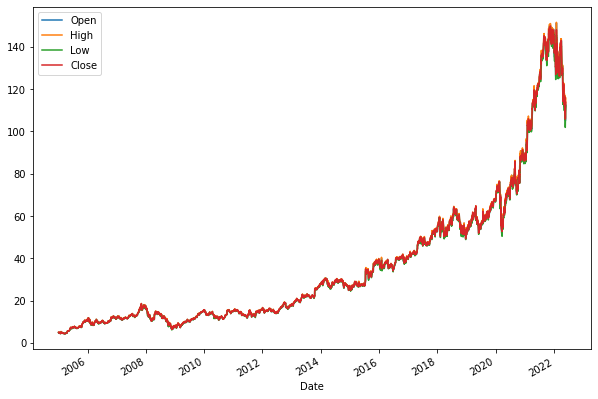

In [16]:
googleDf.plot(figsize=(10,7))

# MODEl One

In [83]:
train_windows, train_labels, test_windows,test_labels=make_windows(googleDf)

In [18]:
model_1=Sequential()
model_1.add(LSTM(128, activation='relu', input_shape=(train_windows.shape[1], train_windows.shape[2])))
model_1.add(Dense(test_labels.shape[1]))
model_1.compile(optimizer='adam', loss='mse')

In [19]:
model_1.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name="model_1")])

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 0.0343

27/27 [==============================] - 9s 199ms/step - loss: 0.0343 - val_loss: 3.3254
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 8.9267e-04

27/27 [==============================] - 6s 215ms/step - loss: 8.9267e-04 - val_loss: 1.2511
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 4.5030e-04

27/27 [==============================] - 5s 191ms/step - loss: 4.5030e-04 - val_loss: 0.5761
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 4.0664e-04

27/27 [==============================] - 5s 176ms/step - loss: 4.0664e-04 - val_loss: 0.1755
Epoch 5/100
27/27 [==============================] - ETA: 0s - loss: 3.7841e-04

27/27 [==============================] - 4s 141ms/step - loss: 3.7841e-04 - val_loss: 0.0230
Epoch 6/100
27/27 [==============================] - 3s 93ms/step - loss: 3.6218e-04 - val_loss: 0.4764
Epoch 7/100
27/27 [==============================] - 3s 93ms/step - loss: 3.4841e-04 - val_loss: 0.4582
Epoch 8/100
27/27 [==============================] - 3s 96ms/step - loss: 3.3949e-04 - val_loss: 0.5036
Epoch 9/100
27/27 [==============================] - 3s 95ms/step - loss: 3.3892e-04 - val_loss: 1.3511
Epoch 10/100
27/27 [==============================] - 3s 95ms/step - loss: 3.3973e-04 - val_loss: 1.4568
Epoch 11/100
27/27 [==============================] - 3s 94ms/step - loss: 3.1301e-04 - val_loss: 1.0097
Epoch 12/100
27/27 [==============================] - 3s 93ms/step - loss: 3.1181e-04 - val_loss: 0.2817
Epoch 13/100
27/27 [==============================] - 3s 94ms/step - loss: 3.0910e-04 - val_loss: 0.1248
Epoch 14/100
27/27 [==============================] - 3s 95ms/step - lo

In [20]:
#load the best version of our model
model_1=tf.keras.models.load_model("model_experiments/model_1")

In [21]:
#Evaluate our model
model_1.evaluate(test_windows,test_labels)

26/26 [==============================] - 0s 12ms/step - loss: 0.0230


0.022978922352194786

In [22]:
#loading the real price from the scaled test labels
model_1_real_stock_price=unscale_labels(googleDf,test_labels)

In [23]:
#preidict the prices 
model_1_pred=predict_unscaled(model_1,googleDf,test_windows)


In [24]:
model_1_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([57.56041 , 57.439117, 57.665043, 58.197075, 58.746513, 59.087738,
       59.304066, 59.37959 , 59.535374, 59.875572], dtype=float32)>

In [25]:
model_1_results=evaluate_preds(y_true=model_1_real_stock_price,
                               y_pred=model_1_pred)

In [26]:
model_1_results

{'mae': 3.307177,
 'mse': 25.54384,
 'rmse': 5.0540915,
 'mape': 3.081993,
 'mase': 2.6730335}

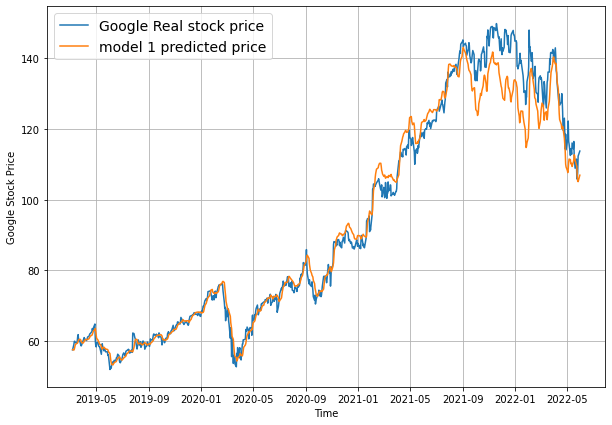

In [84]:
plt.figure(figsize=(10, 7))
plot_time_series( df=googleDf,values=model_1_real_stock_price,test_labels_length=len(test_labels) ,format="-", label="Google Real stock price")
plot_time_series( df=googleDf,values=model_1_pred, format="-",test_labels_length=len(test_labels),  label="model 1 predicted price");

# Model 2

in this second model we will add another feature which is the closing price of the S&p 500 to the features

## Importing data for model2 and preparing it 

In [27]:
# Importinig S&p 500 data from yahoo finance

spSymbol='^GSPC'

spStockData=yf.Ticker(spSymbol)

#Get the S&p 500 data

spDf=spStockData.history(period='1d',start="2005-1-1",end='2022-06-1')

#visualising the data
spDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-01-03,1211.920044,1217.800049,1200.319946,1202.079956,1510800000,0,0
2005-01-04,1202.079956,1205.839966,1185.390015,1188.050049,1721000000,0,0
2005-01-05,1188.050049,1192.729980,1183.719971,1183.739990,1738900000,0,0
2005-01-06,1183.739990,1191.630005,1183.270020,1187.890015,1569100000,0,0
2005-01-07,1187.890015,1192.199951,1182.160034,1186.189941,1477900000,0,0


In [28]:
#Renaming the close Price to SP500
spDf=spDf.rename(columns={'Close':'SP500'})

spDf.head()

,Open,High,Low,SP500,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-01-03,1211.920044,1217.800049,1200.319946,1202.079956,1510800000,0,0
2005-01-04,1202.079956,1205.839966,1185.390015,1188.050049,1721000000,0,0
2005-01-05,1188.050049,1192.729980,1183.719971,1183.739990,1738900000,0,0
2005-01-06,1183.739990,1191.630005,1183.270020,1187.890015,1569100000,0,0
2005-01-07,1187.890015,1192.199951,1182.160034,1186.189941,1477900000,0,0


In [29]:
#Getting the closing price of the s&p500

spClosingPrice=spDf["SP500"]
spClosingPrice.head()

Date
2005-01-03    1202.079956
2005-01-04    1188.050049
2005-01-05    1183.739990
2005-01-06    1187.890015
2005-01-07    1186.189941
Name: SP500, dtype: float64

In [30]:
spClosingPrice.tail()

Date
2022-05-24    3941.479980
2022-05-25    3978.729980
2022-05-26    4057.840088
2022-05-27    4158.240234
2022-05-31    4132.149902
Name: SP500, dtype: float64

In [31]:
# Importinig Google stock data from yahoo finance

GoogleStockSymbol='GOOGL'

GoogleStockData=yf.Ticker(GoogleStockSymbol)

#Get Google stock data

googleDf=GoogleStockData.history(period='1d',start="2005-1-1",end='2022-06-1')

#visualising the data
googleDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-01-03,4.939940,5.096096,4.891391,5.072823,633134232,0,0.0
2005-01-04,5.040040,5.078328,4.841842,4.867367,549685764,0,0.0
2005-01-05,4.841091,4.927427,4.810561,4.842593,329134536,0,0.0
2005-01-06,4.881882,4.902402,4.697698,4.718468,415068516,0,0.0
2005-01-07,4.770771,4.861111,4.724224,4.851101,386129484,0,0.0


In [32]:
googleDf.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-05-24,105.772003,106.458504,101.884499,105.970001,76780000,0,0.0
2022-05-25,104.985497,106.500000,103.856499,105.805000,40258000,0,0.0
2022-05-26,105.677002,108.649498,105.224998,107.792503,37948000,0,0.0
2022-05-27,109.483002,112.318001,109.138496,112.316498,37914000,0,0.0
2022-05-31,112.746498,115.735001,112.078499,113.762001,50012000,0,0.0


In [33]:
#Merging the S&P 500 closing price with the google stock data
model_2_df=pd.merge(spClosingPrice,googleDf[['Open','High','Low','Close']],on='Date')
model_2_df.head()

,SP500,Open,High,Low,Close
Date,,,,,
2005-01-03,1202.079956,4.939940,5.096096,4.891391,5.072823
2005-01-04,1188.050049,5.040040,5.078328,4.841842,4.867367
2005-01-05,1183.739990,4.841091,4.927427,4.810561,4.842593
2005-01-06,1187.890015,4.881882,4.902402,4.697698,4.718468
2005-01-07,1186.189941,4.770771,4.861111,4.724224,4.851101


In [34]:
model_2_df.tail()

,SP500,Open,High,Low,Close
Date,,,,,
2022-05-24,3941.479980,105.772003,106.458504,101.884499,105.970001
2022-05-25,3978.729980,104.985497,106.500000,103.856499,105.805000
2022-05-26,4057.840088,105.677002,108.649498,105.224998,107.792503
2022-05-27,4158.240234,109.483002,112.318001,109.138496,112.316498
2022-05-31,4132.149902,112.746498,115.735001,112.078499,113.762001


## Building model 2

In [81]:
train_windows, train_labels, test_windows,test_labels=make_windows(model_2_df)

In [36]:
model_2=Sequential()
model_2.add(LSTM(128, activation='relu', input_shape=(train_windows.shape[1], train_windows.shape[2])))
model_2.add(Dense(test_labels.shape[1]))
model_2.compile(optimizer='adam', loss='mse')

In [37]:
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name="model_2")])

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 0.0489

27/27 [==============================] - 5s 161ms/step - loss: 0.0489 - val_loss: 0.1387
Epoch 2/100
27/27 [==============================] - 3s 103ms/step - loss: 0.0011 - val_loss: 0.6639
Epoch 3/100
27/27 [==============================] - 3s 102ms/step - loss: 4.4954e-04 - val_loss: 0.7254
Epoch 4/100
27/27 [==============================] - 2s 91ms/step - loss: 3.9544e-04 - val_loss: 0.8740
Epoch 5/100
27/27 [==============================] - 2s 92ms/step - loss: 3.7991e-04 - val_loss: 0.3023
Epoch 6/100
27/27 [==============================] - ETA: 0s - loss: 3.7309e-04

27/27 [==============================] - 4s 143ms/step - loss: 3.7309e-04 - val_loss: 0.1162
Epoch 7/100
27/27 [==============================] - ETA: 0s - loss: 3.6571e-04

27/27 [==============================] - 4s 143ms/step - loss: 3.6571e-04 - val_loss: 0.0550
Epoch 8/100
27/27 [==============================] - ETA: 0s - loss: 3.5680e-04

27/27 [==============================] - 4s 144ms/step - loss: 3.5680e-04 - val_loss: 0.0225
Epoch 9/100
27/27 [==============================] - 2s 92ms/step - loss: 3.5735e-04 - val_loss: 0.0724
Epoch 10/100
27/27 [==============================] - 2s 92ms/step - loss: 3.4443e-04 - val_loss: 0.1480
Epoch 11/100
27/27 [==============================] - 2s 93ms/step - loss: 3.3230e-04 - val_loss: 0.8157
Epoch 12/100
27/27 [==============================] - 2s 92ms/step - loss: 3.2467e-04 - val_loss: 945.2550
Epoch 13/100
27/27 [==============================] - 2s 92ms/step - loss: 3.3185e-04 - val_loss: 13810.8242
Epoch 14/100
27/27 [==============================] - 2s 92ms/step - loss: 3.2414e-04 - val_loss: 432.2992
Epoch 15/100
27/27 [==============================] - 2s 93ms/step - loss: 3.2360e-04 - val_loss: 4456.0679
Epoch 16/100
27/27 [==============================] - 2s 93ms/step - loss: 3.0331e-04 - val_loss: 58531.3672
Epoch 17/100
27/27 [==============================] -

27/27 [==============================] - 4s 155ms/step - loss: 1.8351e-04 - val_loss: 0.0217
Epoch 94/100
27/27 [==============================] - 2s 92ms/step - loss: 1.8203e-04 - val_loss: 0.0295
Epoch 95/100
27/27 [==============================] - 2s 91ms/step - loss: 1.7250e-04 - val_loss: 0.0358
Epoch 96/100
27/27 [==============================] - 2s 90ms/step - loss: 1.6468e-04 - val_loss: 0.0342
Epoch 97/100
27/27 [==============================] - 2s 91ms/step - loss: 1.8048e-04 - val_loss: 0.0351
Epoch 98/100
27/27 [==============================] - 2s 90ms/step - loss: 1.7080e-04 - val_loss: 0.0335
Epoch 99/100
27/27 [==============================] - 2s 90ms/step - loss: 1.7986e-04 - val_loss: 0.0382
Epoch 100/100
27/27 [==============================] - 2s 91ms/step - loss: 2.0673e-04 - val_loss: 0.0298


In [38]:
#load the best version of our model
model_2=tf.keras.models.load_model("model_experiments/model_2")

In [39]:
#Evaluate our model
model_2.evaluate(test_windows,test_labels)

26/26 [==============================] - 0s 13ms/step - loss: 0.0217


0.021712547168135643

In [40]:
#loading the real price from the scaled test labels
model_2_real_stock_price=unscale_labels(model_2_df,test_labels)

In [41]:
#preidict the prices 
model_2_pred=predict_unscaled(model_2,model_2_df,test_windows)


In [42]:
model_2_results=evaluate_preds(y_true=model_2_real_stock_price,
                               y_pred=model_2_pred)

In [43]:
model_2_results

{'mae': 3.3971353,
 'mse': 24.136108,
 'rmse': 4.9128513,
 'mape': 3.044364,
 'mase': 2.7457423}

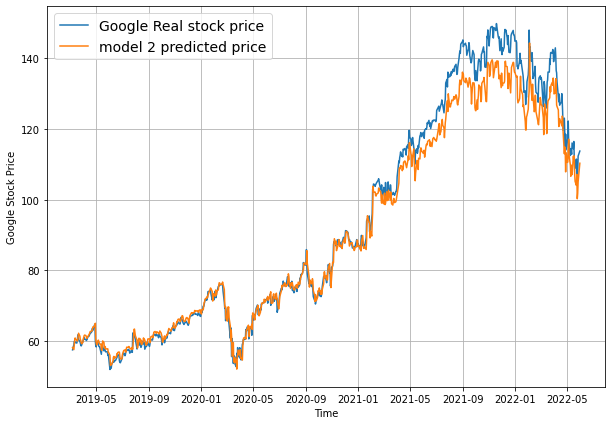

In [82]:
plt.figure(figsize=(10, 7))
plot_time_series( df=model_2_df,values=model_2_real_stock_price,test_labels_length=len(test_labels) ,format="-", label="Google Real stock price")
plot_time_series( model_2_df,values=model_2_pred, format="-",test_labels_length=len(test_labels),  label="model 2 predicted price");

# Model 3

in this model we will use feature engenieering


In [44]:
# Importinig Google stock data from yahoo finance

GoogleStockSymbol='GOOGL'

GoogleStockData=yf.Ticker(GoogleStockSymbol)

#Get Google stock data

df=GoogleStockData.history(period='1d',start="2005-1-1",end='2022-06-1')

#visualising the data
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-01-03,4.939940,5.096096,4.891391,5.072823,633134232,0,0.0
2005-01-04,5.040040,5.078328,4.841842,4.867367,549685764,0,0.0
2005-01-05,4.841091,4.927427,4.810561,4.842593,329134536,0,0.0
2005-01-06,4.881882,4.902402,4.697698,4.718468,415068516,0,0.0
2005-01-07,4.770771,4.861111,4.724224,4.851101,386129484,0,0.0


In [45]:
df_features=generate_technical_features(df)
df_features.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA200,MA100,MA50,...,DIFF-MA200-CLOSE,DIFF-MA100-CLOSE,DIFF-MA50-CLOSE,MA200_low,MA14_low,MA200_high,MA14_high,MA20dSTD,K-ratio,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,4.939940,5.096096,4.891391,5.072823,633134232,0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,5.040040,5.078328,4.841842,4.867367,549685764,0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,4.841091,4.927427,4.810561,4.842593,329134536,0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,4.881882,4.902402,4.697698,4.718468,415068516,0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,4.770771,4.861111,4.724224,4.851101,386129484,0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
#shift the time frame by 10 month

use_start_date = pd.to_datetime("2005-11-01" )
df_features = df_features[df_features.index > use_start_date].copy()
df_features.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA200,MA100,MA50,...,DIFF-MA200-CLOSE,DIFF-MA100-CLOSE,DIFF-MA50-CLOSE,MA200_low,MA14_low,MA200_high,MA14_high,MA20dSTD,K-ratio,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2005-11-02,9.552052,9.634635,9.438689,9.501502,422193384,0,0.0,6.409024,7.567092,7.823038,...,-3.092478,-1.934410,-1.678464,4.318569,7.320821,9.634635,9.634635,0.736901,94.246170,95.430954
2005-11-03,9.569820,9.674174,9.544044,9.658408,297638064,0,0.0,6.433052,7.594019,7.874780,...,-3.225356,-2.064389,-1.783628,4.318569,7.371371,9.674174,9.674174,0.793628,99.315350,96.237588
2005-11-04,9.759259,9.804555,9.645896,9.770521,352643004,0,0.0,6.458346,7.622955,7.928754,...,-3.312175,-2.147566,-1.841767,4.318569,7.537788,9.804555,9.804555,0.845292,98.498576,97.353365
2005-11-07,9.887387,9.946697,9.813564,9.885636,383276340,0,0.0,6.485161,7.652382,7.984535,...,-3.400475,-2.233254,-1.901102,4.318569,7.537788,9.946697,9.946697,0.889136,97.465205,98.426377
2005-11-08,9.866116,9.899650,9.724224,9.757257,315584100,0,0.0,6.511786,7.679810,8.035310,...,-3.245472,-2.077448,-1.721947,4.318569,7.537788,9.946697,9.946697,0.903393,92.135869,96.033217


In [47]:
model_3_df=df_features[['Open','High','Close','RSI','MA200','MA200_high','MA200_low']]
model_3_df.head()

,Open,High,Close,RSI,MA200,MA200_high,MA200_low
Date,,,,,,,
2005-11-02,9.552052,9.634635,9.501502,95.430954,6.409024,9.634635,4.318569
2005-11-03,9.569820,9.674174,9.658408,96.237588,6.433052,9.674174,4.318569
2005-11-04,9.759259,9.804555,9.770521,97.353365,6.458346,9.804555,4.318569
2005-11-07,9.887387,9.946697,9.885636,98.426377,6.485161,9.946697,4.318569
2005-11-08,9.866116,9.899650,9.757257,96.033217,6.511786,9.946697,4.318569


In [48]:
train_windows, train_labels, test_windows,test_labels=make_windows(model_3_df)

In [49]:
model_3=Sequential()
model_3.add(LSTM(128, activation='relu', input_shape=(train_windows.shape[1], train_windows.shape[2])))
model_3.add(Dense(test_labels.shape[1]))
model_3.compile(optimizer='adam', loss='mse')

In [50]:
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name="model_3")])

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.0772

26/26 [==============================] - 5s 152ms/step - loss: 0.0772 - val_loss: 0.0700
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 4s 144ms/step - loss: 0.0019 - val_loss: 0.0520
Epoch 3/100
26/26 [==============================] - 2s 92ms/step - loss: 8.7313e-04 - val_loss: 0.0902
Epoch 4/100
26/26 [==============================] - 2s 90ms/step - loss: 6.4828e-04 - val_loss: 0.2764
Epoch 5/100
26/26 [==============================] - 2s 90ms/step - loss: 5.1753e-04 - val_loss: 0.3960
Epoch 6/100
26/26 [==============================] - 2s 90ms/step - loss: 4.5471e-04 - val_loss: 0.0600
Epoch 7/100
26/26 [==============================] - ETA: 0s - loss: 4.1531e-04

26/26 [==============================] - 4s 154ms/step - loss: 4.1531e-04 - val_loss: 0.0094
Epoch 8/100
26/26 [==============================] - 2s 92ms/step - loss: 3.6946e-04 - val_loss: 0.0549
Epoch 9/100
26/26 [==============================] - 2s 91ms/step - loss: 3.4954e-04 - val_loss: 0.0878
Epoch 10/100
26/26 [==============================] - 2s 90ms/step - loss: 3.3507e-04 - val_loss: 0.1100
Epoch 11/100
26/26 [==============================] - 2s 95ms/step - loss: 3.5110e-04 - val_loss: 0.1978
Epoch 12/100
26/26 [==============================] - 2s 94ms/step - loss: 3.4643e-04 - val_loss: 0.2038
Epoch 13/100
26/26 [==============================] - 2s 90ms/step - loss: 3.2801e-04 - val_loss: 0.1628
Epoch 14/100
26/26 [==============================] - 2s 91ms/step - loss: 3.0223e-04 - val_loss: 0.1928
Epoch 15/100
26/26 [==============================] - 2s 90ms/step - loss: 2.9248e-04 - val_loss: 0.2496
Epoch 16/100
26/26 [==============================] - 2s 90ms/step - 

In [51]:
#load the best version of our model
model_3=tf.keras.models.load_model("model_experiments/model_3")

In [52]:
#loading the real price from the scaled test labels
model_3_real_stock_price=unscale_labels(model_3_df,test_labels)

In [53]:
#preidict the prices 
model_3_pred=predict_unscaled(model_3,model_3_df,test_windows)

In [54]:
model_3_results=evaluate_preds(y_true=model_3_real_stock_price,
                               y_pred=model_3_pred)

In [55]:
model_3_results

{'mae': 2.3101888,
 'mse': 10.537363,
 'rmse': 3.2461305,
 'mape': 2.3749433,
 'mase': 1.8186256}

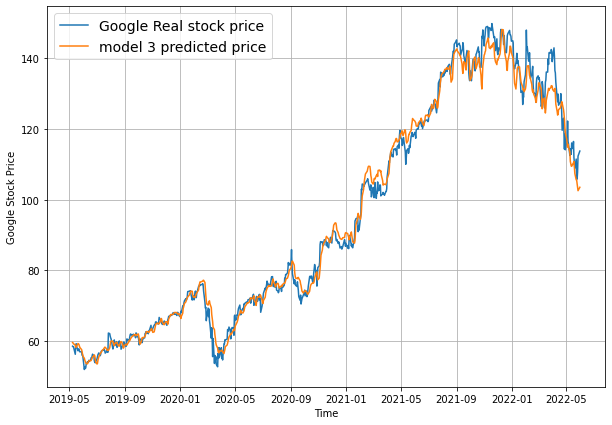

In [79]:
plt.figure(figsize=(10, 7))
plot_time_series( df=model_3_df,values=model_3_real_stock_price,test_labels_length=len(test_labels) ,format="-", label="Google Real stock price")
plot_time_series( model_3_df,values=model_3_pred, format="-",test_labels_length=len(test_labels),  label="model 3 predicted price");

## MODEl 4

in this model we are going to use only the data of the past 5 years in ordr to try if to really old data is irrelevant

In [85]:
# Importinig Google stock data from yahoo finance

GoogleStockSymbol='GOOGL'

GoogleStockData=yf.Ticker(GoogleStockSymbol)

#Get Google stock data

model_4_df=GoogleStockData.history(period='1d',start="2018-1-1",end='2022-06-1')

#visualising the data
model_4_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,31766000,0,0
2018-01-03,53.696499,54.805000,53.671501,54.576000,31318000,0,0
2018-01-04,54.854500,55.203999,54.713001,54.787998,26052000,0,0
2018-01-05,55.172501,55.679001,55.090000,55.514500,30250000,0,0
2018-01-08,55.549999,55.958000,55.500000,55.710499,24644000,0,0


In [86]:
model_4_df=pd.DataFrame(model_4_df[['Open','High','Low','Close']])
model_4_df.head()


,Open,High,Low,Close
Date,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500
2018-01-03,53.696499,54.805000,53.671501,54.576000
2018-01-04,54.854500,55.203999,54.713001,54.787998
2018-01-05,55.172501,55.679001,55.090000,55.514500
2018-01-08,55.549999,55.958000,55.500000,55.710499


In [87]:
train_windows, train_labels, test_windows,test_labels=make_windows(model_4_df)

In [88]:
model_4=Sequential()
model_4.add(LSTM(128, activation='relu', input_shape=(train_windows.shape[1], train_windows.shape[2])))
model_4.add(Dense(test_labels.shape[1]))
model_4.compile(optimizer='adam', loss='mse')

In [89]:
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name="model_4")])

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.2889

7/7 [==============================] - 4s 406ms/step - loss: 0.2889 - val_loss: 0.2565
Epoch 2/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0374 - val_loss: 7072.7681
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0097

7/7 [==============================] - 2s 316ms/step - loss: 0.0097 - val_loss: 0.1635
Epoch 4/100
7/7 [==============================] - 1s 98ms/step - loss: 0.0113 - val_loss: 0.2117
Epoch 5/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0053 - val_loss: 0.3374
Epoch 6/100
7/7 [==============================] - ETA: 0s - loss: 0.0047

7/7 [==============================] - 2s 320ms/step - loss: 0.0047 - val_loss: 0.1492
Epoch 7/100
7/7 [==============================] - ETA: 0s - loss: 0.0043

7/7 [==============================] - 2s 377ms/step - loss: 0.0043 - val_loss: 0.1163
Epoch 8/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0039 - val_loss: 0.1232
Epoch 9/100
7/7 [==============================] - ETA: 0s - loss: 0.0036

7/7 [==============================] - 2s 327ms/step - loss: 0.0036 - val_loss: 0.1161
Epoch 10/100
7/7 [==============================] - ETA: 0s - loss: 0.0033

7/7 [==============================] - 2s 322ms/step - loss: 0.0033 - val_loss: 0.0994
Epoch 11/100
7/7 [==============================] - ETA: 0s - loss: 0.0032

7/7 [==============================] - 2s 319ms/step - loss: 0.0032 - val_loss: 0.0777
Epoch 12/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0031 - val_loss: 0.0978
Epoch 13/100
7/7 [==============================] - ETA: 0s - loss: 0.0030

7/7 [==============================] - 2s 327ms/step - loss: 0.0030 - val_loss: 0.0760
Epoch 14/100
7/7 [==============================] - ETA: 0s - loss: 0.0029

7/7 [==============================] - 2s 386ms/step - loss: 0.0029 - val_loss: 0.0626
Epoch 15/100
7/7 [==============================] - ETA: 0s - loss: 0.0028

7/7 [==============================] - 2s 326ms/step - loss: 0.0028 - val_loss: 0.0207
Epoch 16/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0027 - val_loss: 0.0302
Epoch 17/100
7/7 [==============================] - ETA: 0s - loss: 0.0027

7/7 [==============================] - 2s 324ms/step - loss: 0.0027 - val_loss: 0.0153
Epoch 18/100
7/7 [==============================] - ETA: 0s - loss: 0.0026

7/7 [==============================] - 2s 327ms/step - loss: 0.0026 - val_loss: 0.0127
Epoch 19/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0027 - val_loss: 0.0143
Epoch 20/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0026 - val_loss: 0.0136
Epoch 21/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0025 - val_loss: 0.0134
Epoch 22/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0028 - val_loss: 0.0162
Epoch 23/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0027 - val_loss: 0.0187
Epoch 24/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0027 - val_loss: 0.0154
Epoch 25/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0027 - val_loss: 0.0180
Epoch 26/100
7/7 [==============================] - 1s 94ms/step - loss: 0.0026 - val_loss: 0.0145
Epoch 27/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0025 - val_loss: 0.0140
Epoch 28/100
7/7 [====

7/7 [==============================] - 2s 321ms/step - loss: 0.0026 - val_loss: 0.0127
Epoch 32/100
7/7 [==============================] - 1s 94ms/step - loss: 0.0025 - val_loss: 0.0159
Epoch 33/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0025 - val_loss: 0.0129
Epoch 34/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0024 - val_loss: 0.0136
Epoch 35/100
7/7 [==============================] - 1s 94ms/step - loss: 0.0024 - val_loss: 0.0137
Epoch 36/100
7/7 [==============================] - ETA: 0s - loss: 0.0025

7/7 [==============================] - 2s 388ms/step - loss: 0.0025 - val_loss: 0.0122
Epoch 37/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0025 - val_loss: 0.0136
Epoch 38/100
7/7 [==============================] - ETA: 0s - loss: 0.0026

7/7 [==============================] - 2s 315ms/step - loss: 0.0026 - val_loss: 0.0120
Epoch 39/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0024 - val_loss: 0.0123
Epoch 40/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0023 - val_loss: 0.0120
Epoch 41/100
7/7 [==============================] - ETA: 0s - loss: 0.0023

7/7 [==============================] - 2s 324ms/step - loss: 0.0023 - val_loss: 0.0117
Epoch 42/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 43/100
7/7 [==============================] - 1s 94ms/step - loss: 0.0022 - val_loss: 0.0124
Epoch 44/100
7/7 [==============================] - 1s 94ms/step - loss: 0.0022 - val_loss: 0.0128
Epoch 45/100
7/7 [==============================] - ETA: 0s - loss: 0.0024

7/7 [==============================] - 2s 319ms/step - loss: 0.0024 - val_loss: 0.0116
Epoch 46/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0023 - val_loss: 0.0119
Epoch 47/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0022 - val_loss: 0.0124
Epoch 48/100
7/7 [==============================] - 1s 98ms/step - loss: 0.0023 - val_loss: 0.0157
Epoch 49/100
7/7 [==============================] - 1s 97ms/step - loss: 0.0024 - val_loss: 0.0119
Epoch 50/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0023 - val_loss: 0.0117
Epoch 51/100
7/7 [==============================] - ETA: 0s - loss: 0.0022

7/7 [==============================] - 2s 380ms/step - loss: 0.0022 - val_loss: 0.0115
Epoch 52/100
7/7 [==============================] - 1s 93ms/step - loss: 0.0022 - val_loss: 0.0147
Epoch 53/100
7/7 [==============================] - ETA: 0s - loss: 0.0022

7/7 [==============================] - 2s 322ms/step - loss: 0.0022 - val_loss: 0.0109
Epoch 54/100
7/7 [==============================] - 1s 94ms/step - loss: 0.0022 - val_loss: 0.0124
Epoch 55/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0024 - val_loss: 0.0115
Epoch 56/100
7/7 [==============================] - 1s 94ms/step - loss: 0.0024 - val_loss: 0.0118
Epoch 57/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0024 - val_loss: 0.0145
Epoch 58/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0023 - val_loss: 0.0125
Epoch 59/100
7/7 [==============================] - 1s 94ms/step - loss: 0.0022 - val_loss: 0.0112
Epoch 60/100
7/7 [==============================] - ETA: 0s - loss: 0.0021

7/7 [==============================] - 2s 317ms/step - loss: 0.0021 - val_loss: 0.0108
Epoch 61/100
7/7 [==============================] - ETA: 0s - loss: 0.0020

7/7 [==============================] - 2s 342ms/step - loss: 0.0020 - val_loss: 0.0106
Epoch 62/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0021 - val_loss: 0.0120
Epoch 63/100
7/7 [==============================] - 1s 99ms/step - loss: 0.0021 - val_loss: 0.0118
Epoch 64/100
7/7 [==============================] - 1s 99ms/step - loss: 0.0023 - val_loss: 0.0109
Epoch 65/100
7/7 [==============================] - 1s 98ms/step - loss: 0.0023 - val_loss: 0.0154
Epoch 66/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0024 - val_loss: 0.0128
Epoch 67/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0023 - val_loss: 0.0121
Epoch 68/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0022 - val_loss: 0.0109
Epoch 69/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0021 - val_loss: 0.0135
Epoch 70/100
7/7 [==============================] - ETA: 0s - loss: 0.0020

7/7 [==============================] - 2s 322ms/step - loss: 0.0020 - val_loss: 0.0100
Epoch 71/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0020 - val_loss: 0.0113
Epoch 72/100
7/7 [==============================] - 1s 99ms/step - loss: 0.0022 - val_loss: 0.0108
Epoch 73/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0021 - val_loss: 0.0163
Epoch 74/100
7/7 [==============================] - 1s 96ms/step - loss: 0.0021 - val_loss: 0.0107
Epoch 75/100
7/7 [==============================] - ETA: 0s - loss: 0.0020

7/7 [==============================] - 2s 385ms/step - loss: 0.0020 - val_loss: 0.0099
Epoch 76/100
7/7 [==============================] - ETA: 0s - loss: 0.0020

7/7 [==============================] - 2s 334ms/step - loss: 0.0020 - val_loss: 0.0094
Epoch 77/100
7/7 [==============================] - 1s 128ms/step - loss: 0.0019 - val_loss: 0.0095
Epoch 78/100
7/7 [==============================] - 1s 121ms/step - loss: 0.0021 - val_loss: 0.0096
Epoch 79/100
7/7 [==============================] - 1s 104ms/step - loss: 0.0020 - val_loss: 0.0101
Epoch 80/100
7/7 [==============================] - ETA: 0s - loss: 0.0020

7/7 [==============================] - 2s 393ms/step - loss: 0.0020 - val_loss: 0.0093
Epoch 81/100
7/7 [==============================] - 1s 121ms/step - loss: 0.0021 - val_loss: 0.0107
Epoch 82/100
7/7 [==============================] - ETA: 0s - loss: 0.0020

7/7 [==============================] - 2s 353ms/step - loss: 0.0020 - val_loss: 0.0092
Epoch 83/100
7/7 [==============================] - 1s 144ms/step - loss: 0.0019 - val_loss: 0.0119
Epoch 84/100
7/7 [==============================] - 1s 113ms/step - loss: 0.0021 - val_loss: 0.0110
Epoch 85/100
7/7 [==============================] - 1s 117ms/step - loss: 0.0019 - val_loss: 0.0096
Epoch 86/100
7/7 [==============================] - 1s 92ms/step - loss: 0.0018 - val_loss: 0.0103
Epoch 87/100
7/7 [==============================] - 1s 95ms/step - loss: 0.0021 - val_loss: 0.0099
Epoch 88/100
7/7 [==============================] - 1s 103ms/step - loss: 0.0020 - val_loss: 0.0093
Epoch 89/100
7/7 [==============================] - 1s 122ms/step - loss: 0.0022 - val_loss: 0.0104
Epoch 90/100
7/7 [==============================] - 1s 110ms/step - loss: 0.0020 - val_loss: 0.0120
Epoch 91/100
7/7 [==============================] - 1s 108ms/step - loss: 0.0020 - val_loss: 0.0101
Epoch 92/100
7/

7/7 [==============================] - 3s 482ms/step - loss: 0.0020 - val_loss: 0.0092
Epoch 96/100
7/7 [==============================] - 1s 113ms/step - loss: 0.0019 - val_loss: 0.0099
Epoch 97/100
7/7 [==============================] - ETA: 0s - loss: 0.0019

7/7 [==============================] - 2s 338ms/step - loss: 0.0019 - val_loss: 0.0088
Epoch 98/100
7/7 [==============================] - 1s 98ms/step - loss: 0.0018 - val_loss: 0.0090
Epoch 99/100
7/7 [==============================] - 1s 130ms/step - loss: 0.0018 - val_loss: 0.0089
Epoch 100/100
7/7 [==============================] - 1s 179ms/step - loss: 0.0017 - val_loss: 0.0090


In [90]:
#load the best version of our model
model_4=tf.keras.models.load_model("model_experiments/model_4")

In [91]:
#loading the real price from the scaled test labels
model_4_real_stock_price=unscale_labels(model_4_df,test_labels)

In [92]:
#preidict the prices 
model_4_pred=predict_unscaled(model_4,model_4_df,test_windows)

In [93]:
model_4_results=evaluate_preds(y_true=model_4_real_stock_price,
                               y_pred=model_4_pred)

In [94]:
model_4_results

{'mae': 2.3987117,
 'mse': 8.80899,
 'rmse': 2.9679942,
 'mape': 1.8088251,
 'mase': 1.1200789}

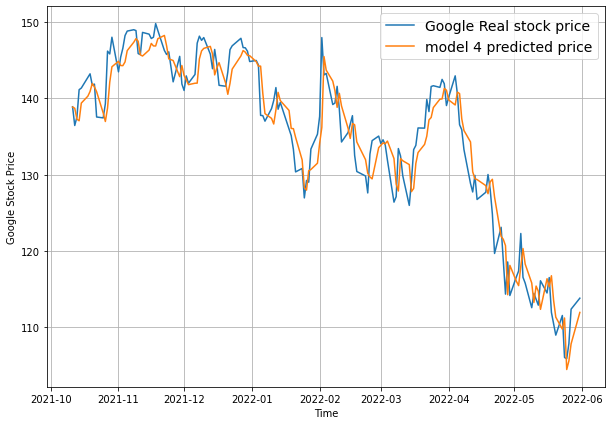

In [96]:
plt.figure(figsize=(10, 7))
plot_time_series( df=model_4_df,values=model_4_real_stock_price,test_labels_length=len(test_labels) ,format="-", label="Google Real stock price")
plot_time_series( model_4_df,values=model_4_pred, format="-",test_labels_length=len(test_labels),  label="model 4 predicted price");